In [2]:
import os
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
import sklearn

from helper import load_data
df_meta, all_codes = load_data(r"/Users/tom.jubb/Documents/data/us_census/", verbose=False)

In [8]:
def describe_feature(x): 
    v = df_meta[df_meta['Var'] == x]['Description'].values
    if len(v) == 0:
        return ''
    else:
        return v[0]
    
def combine_rare_classes(df, col, r=0.1, map_to='other'):
    
    gb = df[[col]].copy()
    gb['count'] = 1
    gb = gb[[col, 'count']].copy().groupby(col).sum().reset_index().sort_values(col, ascending=False)
    gb['count'] = 100*gb['count'] / sum(gb['count'])
    
    mapper = {k:map_to for k in gb[gb['count'] < r][col].values}

    return mapper, gb


def load_data(target='REARNING', 
              age_range = [18,90],
              wage_range = [5000,140000],
             retain: int = 100):
    
    df = pd.read_csv('us_census_data_cleaned_5.csv').drop('Unnamed: 0', axis=1)
    # provide some sensible bounds

    TARGET = 'REARNING'

    # exclude irrelevant data
    assert age_range[0] < age_range[1]
    df = df[df['AGE']      > age_range[0]]
    df = df[df['AGE']      < age_range[1]]

    assert wage_range[0] < wage_range[1]
    df = df[df['REARNING'] > wage_range[0]]
    df = df[df['REARNING'] < wage_range[1]]
    
    mapper, gb = combine_rare_classes(df, 'RACE', 2.0, map_to = 'Other Race 700 799, 986 999')
    df['RACE'] = df['RACE'].apply(lambda x: mapper.get(x, x))
    
    uninformative_columns = []
    for c in df.columns:
        if len(df[c].unique()) == 1:
            print(c)
            uninformative_columns += [c]
    df = df.drop(uninformative_columns, axis=1)
    
    if retain<100:
        df = df.iloc[:int(retain * df.shape[0]),:]
    
    return df

def _prepare_data(df, 
                  target  = 'REARNING', 
                  cols        = None, 
                  cat_cols    = None, 
                  encode_cats = True,
                  verbose     = True):
    
    if cols is None:
        cols = df.columns
    
    categorical_features = []
    if cat_cols is not None:
        categorical_features = cat_cols #[c for c in cats if c in cols]

    valid_cols = [c for c in cols if c in df.columns]
    df_X = df[valid_cols].copy()
    for c in df_X.columns:
        df_X[c] = df_X[c].astype(float, errors='ignore')
    assert target in df_X.columns

    feature_names = [x for x in list(df_X.columns) if x!=target]

    # ordinal encode the categorical features
    le_fitted ={}
    if encode_cats:
        for feature in categorical_features:
            le                 = preprocessing.LabelEncoder()
            le_fitted[feature] = le.fit(df_X[feature].values)
            df_X[feature]      = le_fitted[feature].transform(df_X[feature])
    
        if verbose and len(categorical_features)>0:
            print("Cardinalities")
            print("=============")
            for c in categorical_features:
                print(f"{c:<25} : {len(le_fitted[c].classes_)}")
            
    return df_X, le_fitted

def _split_data(df_X, target, scaler=None, shuffle=True):
    
    X = np.array(df_X.drop(target, axis=1), dtype=float)
    y = np.array(df_X[target], dtype=float)
    
    if shuffle:
            X, y = sklearn.utils.shuffle(X, y)

    n = X.shape[0]
    n_test = int(n*0.05)
    
    if scaler:
        scaler.fit(X)
        X = scaler.transform(X)

    X_train = X[n_test:,:]
    y_train = y[n_test:]

    X_test = X[:n_test,:]
    y_test = y[:n_test]
    
    return X_train, y_train, X_test, y_test


def _regression_metrics(model, X_test, y_test, verbose=True):
    results = {}
    # how did we do?
    results['score'] =model.score(X_test, y_test) 
    if verbose:
        print(f"Score                          : {results['score']:.2f}")

    # the mean error on prediction
    results['mean_abs_err'] = np.abs(model.predict(X_test) - y_test).mean()
    if verbose:
        print(f"Average Error                  : ${results['mean_abs_err']:.0f}")

    r = (model.predict(X_test) > 50000) == (y_test > 50000)
    results['class_err'] = 100 * sum(r) / len(r)
    if verbose:
        print(f"Classification (>$50,000) acc. : {results['class_err']:.2f}")
    
    return results

In [40]:
NUM_FEATURES = [
    'AGE',
    'YEARWRK',
    'FERTIL',
    'HOUR89',
    'HOURS',
    'RIDERS',
    'WEEK89', 
    'TRAVTIME',
    'YRSSERV',
    'REARNING',
    'INCOME1',
    'PWGT1',
    'DEPART',
    'RIDERS',
    'TRAVTIME'
]

from typing import Optional

def _validate_features(df, 
                       target_feature: str, 
                       keep_features: Optional[list] = None, 
                       drop_features: Optional[list] = None):
    
    all_features = df.columns
   
    if keep_features is None:
        # default to keep all features
        keep_features = all_features
    if drop_features is None:
        # default to drop nothing
        drop_features = []

    if target_feature not in all_features:
        print(f"WARNING : target feature {target_feature} not found in data")
        raise RuntimeError(f"WARNING : target feature {target_feature} not found in data")
        
    keep_f = list(set(keep_features))
    drop_f = list(set(drop_features))
        
    if target_feature in keep_f:
        print(f"WARNING : target feature {target_feature} is in keep_feature list, it is not an input feature")
        keep_f.remove(target_feature)
        
    if target_feature in drop_f:
        print(f"WARNING : target feature {target_feature} is in drop_features list, it cannot be dropped")
        drop_f.remove(target_feature)
    
    for feature in drop_f:
        if feature in keep_f:
            print(f"WARNING : keep feature {feature} is also in drop_features!")
            keep_f.remove(feature)
    
    for feature in keep_f:
        if feature not in all_features:
            print(f"WARNING : keep feature {feature} is not in the data!")
            keep_f.remove(feature)
            
    df = df[keep_f + [target_feature]]
    
#     if len(drop_f)>0:
#         df = df.drop(drop_f, axis=1)
    
    features = list(df.columns)
#     features.remove(target_feature)
    
    return df, features
    
def print_features(df):
    print("===== FEATURE LIST ======")
    for x in list(df.columns):
        try:
            vartype = 'NUM' if x in NUM_FEATURES else 'CAT'
            if vartype == 'CAT':
                card = len(df[x].unique())
                print(f"{x:<20} - {vartype} - {card:<4} - {describe_feature(x)}")
            else:
                print(f"{x:<20} - {vartype} -      - {describe_feature(x)}")
        except:
            print(x)
            
def reduce_cardinality(df, feature='OCCUP', group_below=700, new_value='other'):
    
    gb = df.groupby(feature).count().sort_values('AGE')['AGE']
    
    print(f"Old cardinality {gb.shape[0]}")

    low_occup_codes = set(list(gb[gb < group_below].index))
    repl = new_value # min(low_occup_codes)

    df_2 = df.copy()
    df_2[feature] = df[feature].apply(lambda x: repl if x in low_occup_codes else x)
    
    percentage_removed = 100 * sum(df_2[feature] == new_value)/df_2.shape[0]
    
    print(f"New cardinality {len(df_2[feature].unique())}")
    print(fr"{len(low_occup_codes)}/{len(df[feature].unique())} classes ({percentage_removed:.2f}% data) reduced to class {new_value}")
    
    return df_2

In [45]:
def train_linear_regression(df, 
                            target_feature,
                            keep_features = [],
                            drop_features = [],
                            dummy_features = [],
                            model_name="linearRegression",
                            model_params={},
                            reduce_cardinality=False,
                            n_repeats=10, 
                            test_split=0.05,
                            encode_cats=True,
                            scale=True,
                            verbose=True):
    
    df_input, features = _validate_features(df, target_feature, keep_features, drop_features)
    if verbose:
        print_features(df)
    
    print("="*100)
    print("====== PREPARING DATA ============")
    print("="*100 + '\n')
    
    if scale:
        scaler = StandardScaler()
    else:
        scaler = None
        
    if reduce_cardinality:
        df_input = reduce_cardinality(df_input, 'OCCUP',    700, 999)
        df_input = reduce_cardinality(df_input, 'POB',      500, 'other')
        df_input = reduce_cardinality(df_input, 'ANCSTRY1', 500, 999)
        df_input = reduce_cardinality(df_input, 'ANCSTRY2', 500, 999)
        
    if len(dummy_features) > 0:
        dummy_features = list(set(dummy_features))
        dummy_features = [d for d in dummy_features if d not in [target_feature]]
        
        cardinalities = [len(df_input[d].unique()) for d in dummy_features]
        
        
        df_input = pd.get_dummies(df_input,
                                  columns=dummy_features, 
                                  drop_first=True)
        
        features = df_input.columns
    
    
    cat_features = [c for c in features if c not in NUM_FEATURES]
    df_X, encoders = _prepare_data(df_input, 
                        target      = target_feature, 
                        cols        = features, 
                        cat_cols    = cat_features, 
                        encode_cats = encode_cats,
                        verbose     = verbose)
    
    print(f"Rows          : {df_X.shape[0]} Features: {df_X.shape[1]}")

    X_train, y_train, X_test, y_test = _split_data(df_X, target=target_feature, scaler=scaler)
    print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")
    
    print("="*100)
    print("====== TRAINING MODELS ============")
    print("="*100 + '\n')
    
    results = []
    coefs   = []
    models  = []
    
    best_model = None
    best_model_score = -100000.0
    
    model_obj = {"linearRegression":LinearRegression,
                 "gradientBoostedTree":GradientBoostingRegressor}[model_name]
    for i in range(n_repeats):
        
        model = model_obj(**model_params)
        
        print(fr"{i}/{n_repeats}", end='\r')
        X_train, y_train, X_test, y_test = _split_data(df_X, 
                                                       target=target_feature, 
                                                       scaler=scaler, 
                                                       shuffle=True)
        reg      = model.fit(X_train, y_train)
        coefs   += [reg.coef_]
        results += [_regression_metrics(reg, X_test, y_test, verbose=False)]
        models  += [model]
        
        if results[-1]['score'] > best_model_score:
            best_model = model

    err = [r['mean_abs_err'] for r in results]
    
    print("="*100)
    print("====== TESTING MODELS ============")
    print("="*100 + '\n')
    
    print(f"Error : ${np.mean(err):.2f} +/- {np.std(err):.2f}")
    
    
    xvals_ = [c for c in df_X.columns if c != target_feature]
    yvals_, yvals_err_ = np.array(coefs).mean(axis=0), np.array(coefs).std(axis=0)

    fig, ax = plt.subplots(1,1,figsize=(20,6))

    # yvals_ = reg.coef_
    idx = np.argsort(np.abs(yvals_))[::-1]
    xvals     = np.array([xvals_[i] for i in idx])
    yvals     = np.array([yvals_[i] for i in idx])
    yvals_err = np.array([yvals_err_[i] for i in idx])

    plt.scatter(xvals, yvals - yvals_err, color="black", s=10)
    plt.scatter(xvals, yvals + yvals_err, color="black", s=10)

    plt.plot([0,df_X.shape[1]-1],[0,0], color="gray", ls=":")
    for c, coef in zip(xvals, yvals):
        color = 'g' if coef>0 else 'r'
        plt.plot([c,c],[0,coef], color=color)

    plt.xticks(rotation=90)
    plt.show()

    print('\n')
    print("MOST IMPORTANT FEATURES\n")
    for i in np.where((reg.coef_ > 2000) | (reg.coef_ < -2000))[0]:
        col_name = df_X.drop(target_feature, axis=1).columns[i]
        description = describe_feature(col_name)
        print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")


    print('\n')
    print("LEAST IMPORTANT FEATURES\n")
    for i in np.where(abs(reg.coef_) < 50 )[0]:
        col_name = df_X.drop(target_feature, axis=1).columns[i]
        description = describe_feature(col_name)
        print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

    return best_model
        
def train_decision_trees(df, 
                            target_feature,
                            keep_features = [],
                            drop_features = [],
                            model_params={},
                            reduce_card=False,
                            n_repeats=10, 
                            test_split=0.05,
                            encode_cats=True,
                            scale=True,
                            verbose=True):
    
    df, features = _validate_features(df, target_feature, keep_features, drop_features)
    if verbose:
        print_features(df)
    
    print("="*100)
    print("====== PREPARING DATA ============")
    print("="*100 + '\n')
    
    if scale:
        scaler = StandardScaler()
    else:
        scaler = None
    
    if reduce_cardinality:
        df = reduce_cardinality(df, 'OCCUP',    700, 999)
        df = reduce_cardinality(df, 'POB',      500, 'other')
        df = reduce_cardinality(df, 'ANCSTRY1', 500, 999)
        df = reduce_cardinality(df, 'ANCSTRY2', 500, 999)
    
    cat_features = [c for c in features if c not in NUM_FEATURES]
    df_X, _ = _prepare_data(df, 
                        target      = target_feature, 
                        cols        = features, 
                        cat_cols    = cat_features, 
                        encode_cats = encode_cats,
                        verbose     = verbose)
    print(f"Rows          : {df_X.shape[0]} Features: {df_X.shape[1]}")

    X_train, y_train, X_test, y_test = _split_data(df_X, target=target_feature, scaler=scaler)
    print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")
    
    print("="*100)
    print("====== TRAINING MODELS ============")
    print("="*100 + '\n')
    
    results = []
    coefs   = []
    models  = []
    
    model_obj  = GradientBoostingRegressor
    best_model = None
    best_model_score = -100000.0
    
    for i in range(n_repeats):
        model = model_obj(**model_params, verbose=verbose)
        
        print(fr"{i}/{n_repeats}", end='\r')
        X_train, y_train, X_test, y_test = _split_data(df_X, 
                                                       target=target_feature, 
                                                       scaler=scaler, 
                                                       shuffle=True)
        reg      = model.fit(X_train, y_train)
        results += [_regression_metrics(reg, X_test, y_test, verbose=False)]
        models  += [model]
        
        if results[-1]['score'] > best_model_score:
            best_model = model

    print("======= Feature Importance ========")
    importance = {}
    for a,b in zip(df_X.drop(target_feature, axis=1).columns, 
                   best_model.feature_importances_):
        importance[a] = b
    run_total=0.0
    for a,b in dict(sorted(importance.items(), key=lambda item: item[1])[::-1]).items():
        desc = describe_feature(a)
        run_total += b
        print(f"{a:<10} - {b:<5.3f} - {run_total:<3.2f} - {desc}")
        
    err = [r['mean_abs_err'] for r in results]
    
    print("="*100)
    print("====== TESTING MODELS ============")
    print("="*100 + '\n')
    
    print(f"Error : ${np.mean(err):.2f} +/- {np.std(err):.2f}")


    return best_model

def train_neural_network(df, 
                            target_feature,
                            keep_features = [],
                            drop_features = [],
                            model_params={ "random_state":1, "max_iter":300,"learning_rate_init":0.01},
                            n_repeats=10, 
                            test_split=0.05,
                            encode_cats=True,
                            scale=True,
                            verbose=True):
    
    df, features = _validate_features(df, target_feature, keep_features, drop_features)
    if verbose:
        print_features(df)
    
    print("="*100)
    print("====== PREPARING DATA ============")
    print("="*100 + '\n')
    
    if scale:
        scaler = StandardScaler()
    else:
        scaler = None
    
    cat_features = [c for c in features if c not in NUM_FEATURES]
    df_X, _ = _prepare_data(df, 
                        target      = target_feature, 
                        cols        = features, 
                        cat_cols    = cat_features, 
                        encode_cats = encode_cats,
                        verbose     = verbose)
    print(f"Rows          : {df_X.shape[0]} Features: {df_X.shape[1]}")

    X_train, y_train, X_test, y_test = _split_data(df_X, target=target_feature, scaler=scaler)
    print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")
    
    print("="*100)
    print("TRAINING MODELS")
    print("="*100 + '\n')
    
    results = []
    coefs   = []
    models  = []
    
    model_obj  = MLPRegressor
    best_model = None
    best_model_score = -100000.0
    
    for i in range(n_repeats):
        model = model_obj(**model_params, 
                          hidden_layer_sizes=(X_train.shape[1],
                                              X_train.shape[1],
                                              X_train.shape[1]),
                          verbose=verbose)
        
        print(fr"{i}/{n_repeats}", end='\r')
        X_train, y_train, X_test, y_test = _split_data(df_X, 
                                                       target=target_feature, 
                                                       scaler=scaler, 
                                                       shuffle=True)
        for i in range(100):
            model.partial_fit(X_train, y_train)
            if verbose:
                print(f"${np.abs(model.predict(X_test) - y_test).mean():.2f}")
    
        results += [_regression_metrics(model, X_test, y_test, verbose=False)]
        models  += [model]
        
        if results[-1]['score'] > best_model_score:
            best_model = model

    print("======= Feature Importance ========")
    importance = {}
    for a,b in zip(df_X.drop(target_feature, axis=1).columns, 
                   best_model.feature_importances_):
        importance[a] = b
    run_total=0.0
    for a,b in dict(sorted(importance.items(), key=lambda item: item[1])[::-1]).items():
        desc = describe_feature(a)
        run_total += b
        print(f"{a:<10} - {b:<5.3f} - {run_total:<3.2f} - {desc}")
        
    err = [r['mean_abs_err'] for r in results]
    
    print("="*100)
    print("====== TESTING MODELS ============")
    print("="*100 + '\n')
    
    print(f"Error : ${np.mean(err):.2f} +/- {np.std(err):.2f}")


    return best_model

## Training Data

In [9]:
df = load_data(target    = 'REARNING', 
              age_range  = [18,90],
              wage_range = [5000,140000], 
              retain     = 50)

ROWNCHLD
WORK89


In [10]:
print_features(df)

===== FEATURE LIST ======
AGE                  - NUM -      - Age
ANCSTRY1             - CAT - 255  - Ancestry First Entry See Appendix I Ance
ANCSTRY2             - CAT - 192  - Ancestry Second Entry See Appendix I Anc
CITIZEN              - CAT - 2    - Citizenship
CLASS                - CAT - 8    - Class of Worker
DEPART               - NUM -      - Time of Departure for Work Hour and Minu
DISABL1              - CAT - 2    - Work Limitation Stat.
ENGLISH              - CAT - 5    - Ability to Speak English
FEB55                - CAT - 2    - Served February 1955 July 1964
FERTIL               - NUM -      - No. of Chld. Ever Born
HISPANIC             - CAT - 56   - Detailed Hispanic Origin Code See Append
HOUR89               - NUM -      - Usual Hrs. Worked Per Week Last Yr. 1989
HOURS                - NUM -      - Hrs. Worked Last Week
IMMIGR               - CAT - 11   - Yr. of Entry
INDUSTRY             - CAT - 243  - Ind. See Appendix I Ind..lst
KOREAN               - CAT - 2  

## Training : Linear Models

===== FEATURE LIST ======
AGE                  - NUM -      - Age
ANCSTRY1             - CAT - 255  - Ancestry First Entry See Appendix I Ance
ANCSTRY2             - CAT - 192  - Ancestry Second Entry See Appendix I Anc
CITIZEN              - CAT - 2    - Citizenship
CLASS                - CAT - 8    - Class of Worker
DEPART               - NUM -      - Time of Departure for Work Hour and Minu
DISABL1              - CAT - 2    - Work Limitation Stat.
ENGLISH              - CAT - 5    - Ability to Speak English
FEB55                - CAT - 2    - Served February 1955 July 1964
FERTIL               - NUM -      - No. of Chld. Ever Born
HISPANIC             - CAT - 56   - Detailed Hispanic Origin Code See Append
HOUR89               - NUM -      - Usual Hrs. Worked Per Week Last Yr. 1989
HOURS                - NUM -      - Hrs. Worked Last Week
IMMIGR               - CAT - 11   - Yr. of Entry
INDUSTRY             - CAT - 243  - Ind. See Appendix I Ind..lst
KOREAN               - CAT - 2  

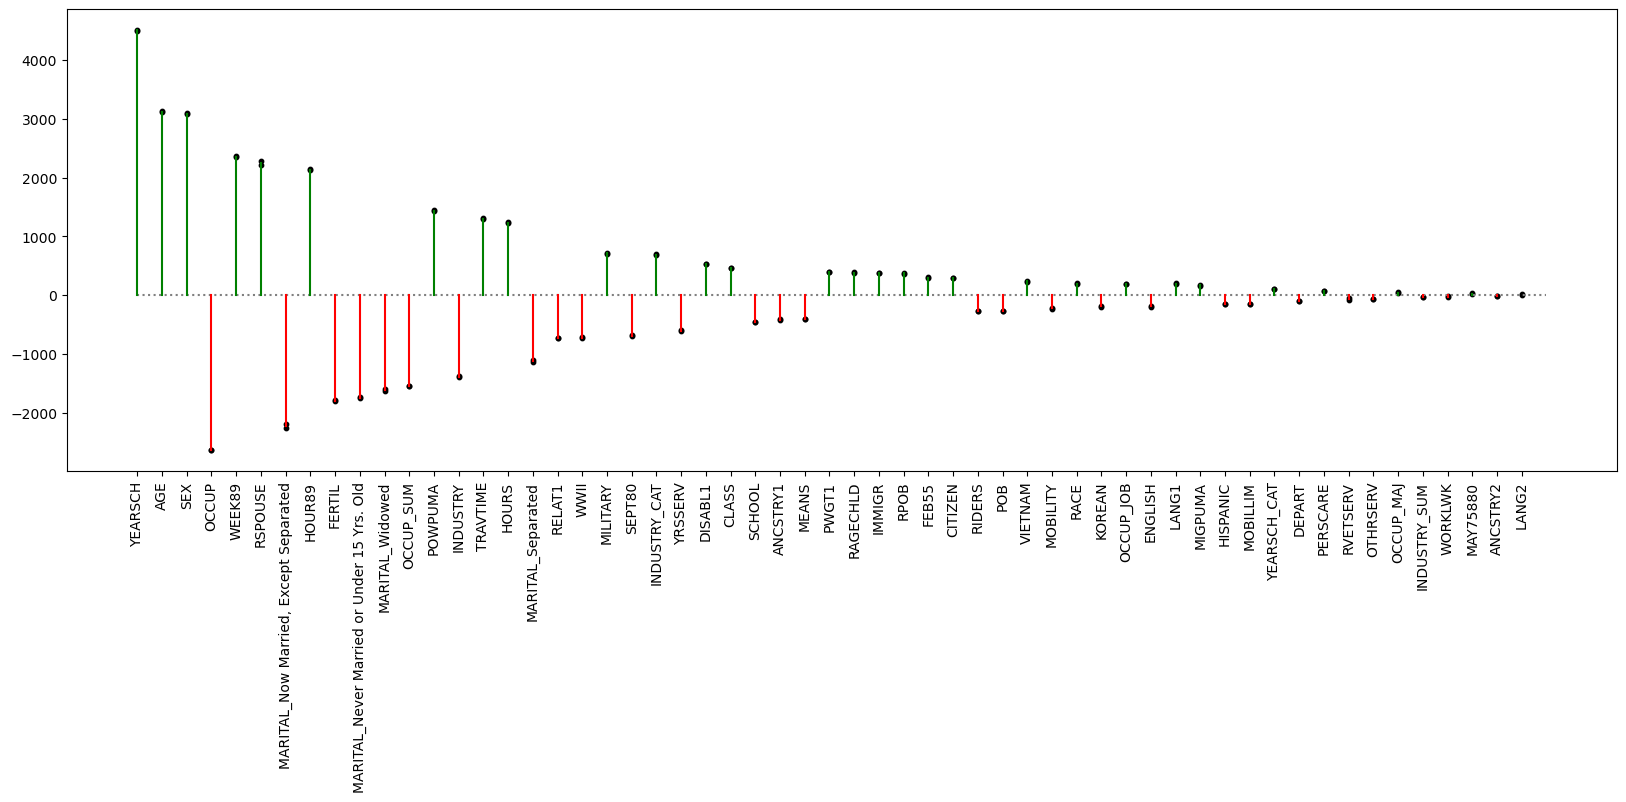



MOST IMPORTANT FEATURES

HOUR89     2140.79    Usual Hrs. Worked Per Week Last Yr. 1989
AGE        3122.96    Age
YEARSCH    4498.67    Ed. Attainment
OCCUP      -2636.58   Occupation See Appendix I Occup.lst
RSPOUSE    2272.95    Married. Spouse Present/spouse Absent
WEEK89     2354.99    Wks. Worked Last Yr. 1989
SEX        3095.20    Sex
MARITAL_Now Married, Except Separated -2265.07   


LEAST IMPORTANT FEATURES

MAY75880   25.90      Served May 1975 to August 1980
WORKLWK    -24.57     Worked Last Week
OCCUP_MAJ  39.48      
ANCSTRY2   -17.72     Ancestry Second Entry See Appendix I Anc
INDUSTRY_SUM -24.12     
LANG2      10.16      Language Spoken At Home See Appendix I L


In [18]:
model = train_linear_regression(df, 
                        target_feature ='REARNING',
                        keep_features  = None,
                        drop_features  = ['MIGSTATE','POWSTATE'],
                        dummy_features = ['MARITAL'],
                        n_repeats      = 10, 
                        test_split     = 0.05,
                        encode_cats    = True,
                        scale          = True,
                        verbose        = True)

## Training : Decision Tree Models

In [49]:
model = train_decision_trees(df, 
                        target_feature ='REARNING',
                        keep_features  = None,
                        drop_features  = ['MIGSTATE','POWSTATE','OCCUP_JOB','LANG2','MIGPUMA','POWPUMA','INDUSTRY_CAT'],
                        n_repeats      = 1, 
                        model_params   = {"n_estimators":200, "max_depth":9, "learning_rate":0.25},
                        reduce_card    = True,
                        test_split     = 0.05,
                        encode_cats    = True,
                        scale          = False,
                        verbose        = True)

===== FEATURE LIST ======
HISPANIC             - CAT - 56   - Detailed Hispanic Origin Code See Append
DISABL1              - CAT - 2    - Work Limitation Stat.
RAGECHLD             - CAT - 5    - Presence and Age of Own Chld.
MARITAL              - CAT - 5    - Marital Stat.
HOUR89               - NUM -      - Usual Hrs. Worked Per Week Last Yr. 1989
MAY75880             - CAT - 2    - Served May 1975 to August 1980
CLASS                - CAT - 8    - Class of Worker
WORKLWK              - CAT - 2    - Worked Last Week
OCCUP_MAJ            - CAT - 14   - 
TRAVTIME             - NUM -      - Travel Time to Work
LANG1                - CAT - 2    - Language Other Than English At Home
FEB55                - CAT - 2    - Served February 1955 July 1964
MILITARY             - CAT - 2    - Military Srvc.
AGE                  - NUM -      - Age
RPOB                 - CAT - 14   - Place of Birth Recode
YEARSCH              - CAT - 17   - Ed. Attainment
CITIZEN              - CAT - 2    - Citize

KeyboardInterrupt: 

## Training : Neural Network

In [ ]:
model = train_neural_network(df, 
                        target_feature,
                        keep_features = [],
                        drop_features = ['MIGSTATE','POWSTATE'],
                        model_params={ "random_state":1, "max_iter":300,"learning_rate_init":0.01},
                        n_repeats=10, 
                        test_split=0.05,
                        encode_cats=True,
                        scale=True,
                        verbose=True)

## Testing

In [78]:
GradientBoostingRegressor(**{"max_iter":200, "max_depth":9, "learning_rate":0.25})

TypeError: __init__() got an unexpected keyword argument 'max_iter'

In [37]:
def reduce_cardinality(df, feature='OCCUP', group_below=700, new_value='other'):
    
    gb = df.groupby(feature).count().sort_values('AGE')['AGE']
    
    print(f"Old cardinality {gb.shape[0]}")

    low_occup_codes = set(list(gb[gb < group_below].index))
    repl = new_value # min(low_occup_codes)

    df_2 = df.copy()
    df_2[feature] = df[feature].apply(lambda x: repl if x in low_occup_codes else x)
    
    percentage_removed = 100 * sum(df_2[feature] == new_value)/df_2.shape[0]
    
    print(f"New cardinality {len(df_2[feature].unique())}")
    print(fr"{len(low_occup_codes)}/{len(df[feature].unique())} classes ({percentage_removed:.2f}% data) reduced to class {new_value}")
    
    return df_2

In [38]:
df_2 = reduce_cardinality(df,   'OCCUP', 700)
df_2 = reduce_cardinality(df_2, 'OCCUP_JOB', 700)
df_2 = reduce_cardinality(df_2, 'POB', 500)

df_2 = reduce_cardinality(df_2, 'ANCSTRY1', 500)
df_2 = reduce_cardinality(df_2, 'ANCSTRY2', 500)
df_2 = reduce_cardinality(df_2, 'INDUSTRY_CAT', 500)

Old cardinality 504
New cardinality 222
283/504 classes (8.12% data) reduced to class other
Old cardinality 504
New cardinality 222
283/504 classes (8.12% data) reduced to class other
Old cardinality 267
New cardinality 88
180/267 classes (1.65% data) reduced to class other
Old cardinality 255
New cardinality 74
182/255 classes (1.30% data) reduced to class other
Old cardinality 192
New cardinality 37
156/192 classes (0.68% data) reduced to class other
Old cardinality 238
New cardinality 211
28/238 classes (0.96% data) reduced to class other


In [31]:
print_features(df_2)

===== FEATURE LIST ======
AGE                  - NUM -      - Age
ANCSTRY1             - CAT - 74   - Ancestry First Entry See Appendix I Ance
ANCSTRY2             - CAT - 37   - Ancestry Second Entry See Appendix I Anc
CITIZEN              - CAT - 2    - Citizenship
CLASS                - CAT - 8    - Class of Worker
DEPART               - NUM -      - Time of Departure for Work Hour and Minu
DISABL1              - CAT - 2    - Work Limitation Stat.
ENGLISH              - CAT - 5    - Ability to Speak English
FEB55                - CAT - 2    - Served February 1955 July 1964
FERTIL               - NUM -      - No. of Chld. Ever Born
HISPANIC             - CAT - 56   - Detailed Hispanic Origin Code See Append
HOUR89               - NUM -      - Usual Hrs. Worked Per Week Last Yr. 1989
HOURS                - NUM -      - Hrs. Worked Last Week
IMMIGR               - CAT - 11   - Yr. of Entry
INDUSTRY             - CAT - 243  - Ind. See Appendix I Ind..lst
KOREAN               - CAT - 2  

In [26]:
df_2

,AGE,ANCSTRY1,ANCSTRY2,CITIZEN,CLASS,DEPART,DISABL1,ENGLISH,FEB55,FERTIL,...,WORKLWK,WWII,YEARSCH,YRSSERV,YEARSCH_CAT,OCCUP_JOB,OCCUP_SUM,OCCUP_MAJ,INDUSTRY_CAT,INDUSTRY_SUM
0,43,50,999,True,Fed. Gov. Emp.,260,2,0,0,0,...,True,0,15,4,Masters Degree,"Administrators and officials, public administr...",MANAGERIAL AND PROFESSIONAL SPECIALTY OCCUPATIONS,"Executive, Administrative, and Managerial Occu...",Administration of economic programs (96),PUBLIC ADMINISTRATION
3,27,148,999,True,Emp. of a Private for Profit Company or,540,2,0,0,0,...,True,0,14,0,Bachelors Degree,"Sales representatives, mining, manufacturing, ...","TECHNICAL, SALES, AND ADMINISTRATIVE SUPPORT O...",Sales Occupations,Beverage industries (208),MANUFACTURING
5,31,999,999,True,Emp. of a Private for Profit Company or,435,2,0,0,0,...,True,0,11,0,"Some Coll., But No Degree","Sales representatives, mining, manufacturing, ...","TECHNICAL, SALES, AND ADMINISTRATIVE SUPPORT O...",Sales Occupations,"Hardware, plumbing and heating supplies (507)",WHOLESALE TRADE
6,30,999,999,True,"Local Gov. Emp. City, County, Etc.",480,2,1,0,3,...,True,0,11,0,"Some Coll., But No Degree","Cooks (5214, 5215)",SERVICE OCCUPATIONS,"Service Occupations, Except Protective and Hou...",Elementary and secondary schools (821),PROFESSIONAL AND RELATED SERVICES
8,45,32,999,True,Emp. of a Private for Profit Company or,420,2,0,0,0,...,True,0,5,1,"5th, 6th, 7th, or 8th Grade","Miscellaneous machine operators, n.e.c. (part ...","OPERATORS, FABRICATORS, AND LABORERS","Machine Operators, Assemblers, and Inspectors",Wood buildings and mobile homes (245),MANUFACTURING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118451,32,32,999,True,Emp. of a Private for Profit Company or,375,2,0,0,0,...,True,0,11,0,"Some Coll., But No Degree","Freight, stock, and material handlers, n.e.c. ...","OPERATORS, FABRICATORS, AND LABORERS","Handlers, Equipment Cleaners, Helpers, and Lab...",MINING,MINING
1118452,33,82,999,True,Emp. of a Private for Profit Company or,390,2,0,0,3,...,True,0,11,0,"Some Coll., But No Degree","Managers, properties and real estate (1353)",MANAGERIAL AND PROFESSIONAL SPECIALTY OCCUPATIONS,"Executive, Administrative, and Managerial Occu...",MINING,MINING
1118453,41,97,999,True,Emp. of a Private for Profit Company or,360,2,0,0,0,...,True,0,12,4,"Associate Degree in Coll., Occupational","Welders and cutters (7332, 7532, 7714)","OPERATORS, FABRICATORS, AND LABORERS","Machine Operators, Assemblers, and Inspectors",MINING,MINING
1118454,39,22,999,True,Emp. of a Private for Profit Company or,480,2,1,0,2,...,True,0,15,0,Masters Degree,"Teachers, secondary school (233)",MANAGERIAL AND PROFESSIONAL SPECIALTY OCCUPATIONS,Professional Specialty Occupations,Elementary and secondary schools (821),PROFESSIONAL AND RELATED SERVICES
